In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
class RemoveFirstFrame(BaseEstimator, TransformerMixin):
    def __init__(self, frame):
        self.frame = frame
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.query(f"Step % {frame} != 1")
def choose_top_rw(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.Rw, method='first')<=n)
def choose_top_vtotal(data,n=5):
    return data.assign(chosen=pd.DataFrame.rank(data.VTotal, method='first')<=n)
def choose_top(data,col="Qw", n=5, ascending=False):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='first')<=n)

In [4]:
FEATURES = ['Rw',
#      'VTotal',
#      'QGO',
#      'VwithoutGo',
     'Burial',
     'Water',
     'Rama',
#      'DSSP',
#      'P_AP',
     'Helix',
#      'Frag_Mem'
               ]
n = 5
def my_transform(data, label, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

def my_transform_predict(data, degree, FEATURES=FEATURES):

    # LABEL = "Qw"
    PolynomialDegree = degree

    num_attribs = FEATURES
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    return num_pipeline.fit_transform(data)

In [5]:
raw_test_data = pd.read_csv("/Users/weilu/Research/data/test_data/complete_data_mar27.csv", index_col=0)
raw_data_T0784 = raw_test_data.groupby("Name").get_group("T0784")
# raw_data_T0792 = raw_test_data.groupby("Name").get_group("T0792")
# raw_data = pd.concat([raw_data_T0784, raw_data_T0792])
# raw_data = raw_data_T0792
# raw_data = raw_test_data.groupby("Name").get_group("1mba")
raw_data = raw_data_T0784

In [6]:
# FEATURES = ["Rw", "VTotal", "QGO"]
# FEATURES = ["Rw", "VTotal", "QGO", "Burial", "Frag_Mem", "Water"]
# FEATURES = list(raw_test_data.columns[2:-3])
def train_and_test(raw_data, label="Qw", degree=1, p=0.1):
    # my_full_pipeline = Pipeline([
    # #         ('removeFirstFrame', RemoveFirstFrame(frame)),
    #         ('featureSelection', full_pipeline)
    # ])

    from sklearn.model_selection import StratifiedShuffleSplit

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=142)
    for train_index, test_index in split.split(raw_data, raw_data["isGood"]):
        strat_train_set = raw_data.iloc[train_index]
        strat_test_set = raw_data.iloc[test_index]
    # strat_test_set[LABEL].value_counts() / len(strat_test_set)
    X_train = my_transform(strat_train_set, label, degree)
    X_test = my_transform(strat_test_set, label, degree)
    train_y = X_train[:,-1]
    train_set = X_train[:,:-1]
    test_y = X_test[:,-1]
    test_set = X_test[:,:-1]
    return (train_set, train_y, test_set, test_y)
label = "isGood"
degree = 1
p = 0.1
train_set, train_y, test_set, test_y = train_and_test(raw_data, label=label, degree=degree)
log_clf = LogisticRegression(random_state=140, penalty='l2')

# log_clf = LogisticRegression(random_state=14, class_weight={0:p, 1:(1-p)}, penalty='l1')
log_clf.fit(train_set, train_y)
# y_pred = log_clf.predict(train_set)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=140, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
protein_list = ["T0949", "T0950"]
name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB" , "Electro.", "QGO" ,"VTotal"]
all_data_list = []
for protein in protein_list:
    for i in range(1,4):
        awsem = pd.read_table(f"/Users/weilu/Research/server/casp13/result/{protein}/post-processing/model.{i}/awsem_energy/awsem.log", names=name_list)
        rw = pd.read_table(f"/Users/weilu/Research/server/casp13/result/{protein}/post-processing/model.{i}/lowTstructure/rwplusScore.short.txt", names=["i", "Rw"], sep="\s+")
        rw = rw.reset_index(drop=True)
        awsem = awsem.reset_index().drop("Step", axis=1).rename(columns={"index":"Step"}).assign(model=i)
        data = pd.concat([rw, awsem], axis=1)
        remove_columns = ['i', "Shake", "Excluded", "Membrane", "Vec_FM", "SSB", "Electro."]
        all_data_list.append(data.drop(remove_columns, axis=1).assign(Name=protein))
data = pd.concat(all_data_list)

In [19]:
prediction_list = []
for name, data in data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
#     X = my_transform(data, label, degree)
#     eval_y = X[:,-1]
#     eval_set = X[:,:-1]
    X = my_transform_predict(data, degree)
    eval_set = X
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = raw_test_data.assign(prediction=prediction.values)
best_by_prediction = t.drop_duplicates(subset=['prediction', 'Rw', "VTotal"]).groupby("Name").apply(choose_top, n=10, col="prediction").query("chosen==True")

T0949
T0950


In [24]:
t.drop_duplicates(subset=['prediction', 'Rw', "VTotal"]).rename(columns={"prediction":"score"}).\
    to_csv("/Users/weilu/Dropbox/IAAWSEM/casp13/selection/all_atom_refinement_energy_rw_and_score_by_ml.csv")

In [21]:
for name, one in best_by_prediction.reset_index(drop=True).groupby("Name"):
    print(name)
#     print(a.sort_values("prediction", ascending=False).reset_index())
    for i,a in one.sort_values("prediction", ascending=False).reset_index().iterrows():
        print(name, "model", a["model"], "Step", a["Step"])
        from_loc = f"/Users/weilu/Research/server/casp13/result/{name}/post-processing/model.{a['model']}/lowTstructure/lowTstructure{a['Step']}.pdb"
        to_loc = f"/Users/weilu/Dropbox/IAAWSEM/casp13/selection/selected/{name}_chosen_{i}.pdb"
        os.system("cp "+from_loc+" "+to_loc)

T0949
T0949 model 2 Step 0
T0949 model 1 Step 0
T0949 model 2 Step 82
T0949 model 2 Step 90
T0949 model 2 Step 81
T0949 model 2 Step 89
T0949 model 3 Step 0
T0949 model 2 Step 93
T0949 model 2 Step 84
T0949 model 2 Step 92
T0950
T0950 model 1 Step 0
T0950 model 2 Step 0
T0950 model 3 Step 0
T0950 model 1 Step 32
T0950 model 1 Step 89
T0950 model 1 Step 33
T0950 model 1 Step 62
T0950 model 1 Step 71
T0950 model 1 Step 75
T0950 model 1 Step 64


In [ ]:
t.drop_duplicates(subset=['prediction', 'Rw', "VTotal"])

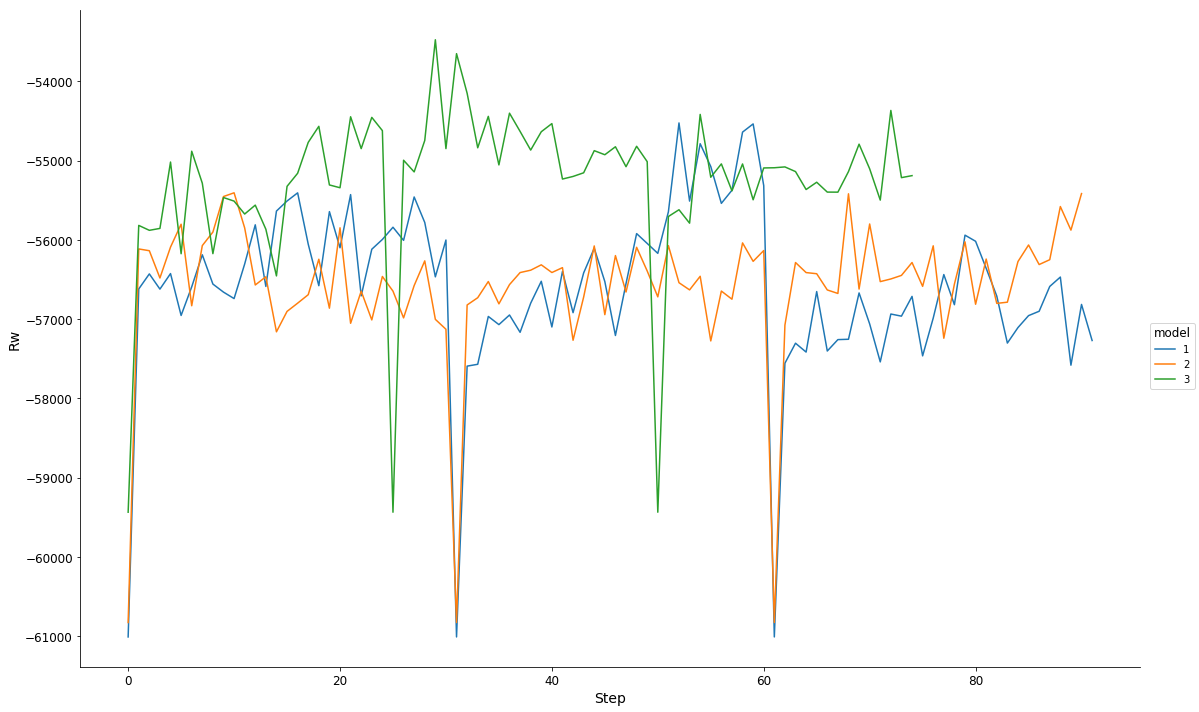

In [25]:
import seaborn
fg = seaborn.FacetGrid(data=t.query("Name == 'T0950'"), hue='model',  aspect=1.61, size=10)
fg.map(plt.plot, 'Step', 'Rw').add_legend()

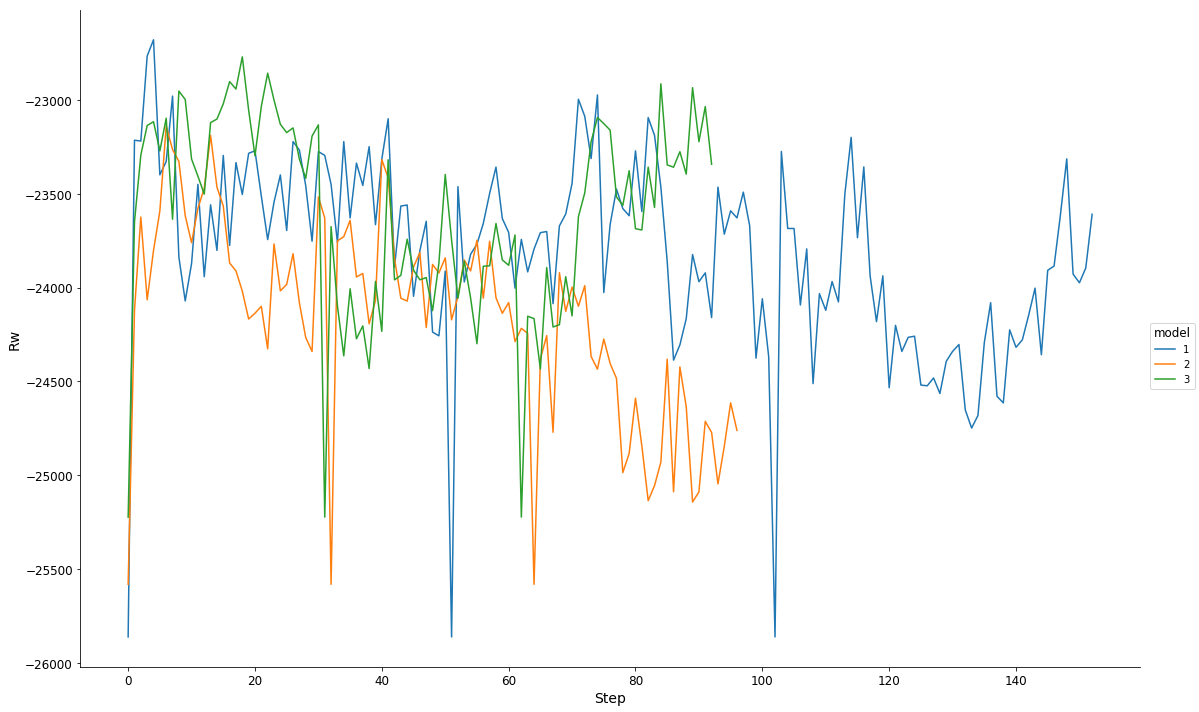

In [11]:
import seaborn
fg = seaborn.FacetGrid(data=t.query("Name == 'T0949'"), hue='model',  aspect=1.61, size=10)
fg.map(plt.plot, 'Step', 'Rw').add_legend()

In [ ]:
# n = 100
prediction_list = []
for name, data in raw_test_data.groupby("Name"):
    print(name)
#     X = full_pipeline.fit_transform(data)
#     X = my_transform(data, label, degree)
#     eval_y = X[:,-1]
#     eval_set = X[:,:-1]
    X = my_transform_predict(data, degree)
    eval_set = X
    test= log_clf.predict_proba(eval_set)[:,1]
    one = data.assign(prediction=test)
    prediction_list.append(one)
#     prediction_list.append(pd.Series(test))
t = pd.concat(prediction_list)
# t = raw_test_data.assign(prediction=prediction.values)
best_by_prediction = t.groupby("Name").apply(choose_top, n=5, col="prediction").query("chosen==True")